In [7]:
import numpy as np
# import matplotlib.pyplot as plt
import math
import scipy.special as sp
from scipy.optimize import fsolve

# from numpy.polynomial.legendre import Legendre

np.set_printoptions(precision=16)

#Parameters
prho = 60
pz = 30

Lr = 5
Lz = 5
# SIGMA_r = 1
A0 = 0.002
# r0 = 2


LZ = Lz
LR = Lr
PR = prho
PZ = pz

##COLLOCATION POINTS

# collocation points for rho
# k_full = np.arange(0, 2*prho + 4)
# x__col = np.cos(np.pi * k_full / (2*prho + 3))
# den = np.sqrt(1 - x__col**2)
# den = np.where(den < 1e-14, 1e-14, den)
# r_col_prel = Lr * x__col / den
# rho_col = r_col_prel[prho+1:0:-1]
# # np.savetxt('rcol_6030L1_testH', r_col, fmt='%.16f')
# # print('rho=', rho_col)  CONFERE

# N = 2 * pz + 4  
# k = np.arange(1, pz + 2)  
# theta = np.pi * (pz + 2 - k) / (2 * pz + 3)
# z_col_pre = Lz / np.tan(theta)
# z_col = np.sort(z_col_pre)

k_values = np.arange(0, 2 * prho + 4)
x_col = np.cos(np.pi * k_values / (2 * prho + 3))
r_col_pre = Lr * x_col / np.sqrt(1 - x_col**2)
# rcol = r_col_pre[PR+1:0:-1]

rho_col = np.zeros(prho + 1)
for k in range(1, prho + 2):
    rho_col[k - 1] = r_col_pre[prho + 2 - k]

k_val = np.arange(0, 2 * PZ + 4)
y_col = np.cos(np.pi * k_val / (2 * PZ + 3))
z_col_pre = LZ * y_col / np.sqrt(1 - y_col**2)
# zcol = z_col_pre[PZ+1:0:-1]
z_col = np.zeros(PZ + 1)
for k in range(1, PZ + 2):
    z_col[k - 1] = z_col_pre[PZ + 2 - k]

C:\Users\belmo\AppData\Local\Temp\ipykernel_1844\2205158998.py:47: RuntimeWarning: divide by zero encountered in divide
  r_col_pre = Lr * x_col / np.sqrt(1 - x_col**2)
C:\Users\belmo\AppData\Local\Temp\ipykernel_1844\2205158998.py:56: RuntimeWarning: divide by zero encountered in divide
  z_col_pre = LZ * y_col / np.sqrt(1 - y_col**2)


In [8]:
######### 2n+1 #########
##BASES
#r basis

def SB(n, r):
    res = np.sin((n + 1) * ((np.pi / 2) - np.arctan(r / Lr)))
    # np.sin((n+1)*np.arctan(Lr/r)) 
    # np.sin((n + 1) * ((np.pi / 2) - np.arctan(r / Lr)))
    return res

def rSB(n, r):
    res = - np.cos((n + 1) * ((np.pi / 2) - np.arctan(r / Lr))) * (n + 1) / (Lr * (1 + (r / Lr)**2))
    
    # -np.cos((n+1)*np.arctan(Lr/r))*(n+1)*Lr/(r**2*(1+Lr**2/r**2)) 
    # - np.cos((n + 1) * ((np.pi / 2) - np.arctan(r / Lr))) * (n + 1) / (Lr * (1 + (r / Lr)**2))
    return res

def rrSB(n, r):
    res = (2 * np.cos((n + 1) * (np.pi / 2 - np.arctan(r / Lr))) *
           (n + 1) * r / (Lr**3 * (1 + (r / Lr)**2)**2)
           - np.sin((n + 1) * (np.pi / 2 - np.arctan(r / Lr))) *
           (n + 1)**2 / (Lr**2 * (1 + (r / Lr)**2)**2))
    
    # (-np.sin((n+1)*np.arctan(Lr/r))*(n+1)**2*Lr**2/(r**4*(1+Lr**2/r**2)**2)
    # + 2*np.cos((n+1)*np.arctan(Lr/r))*(n+1)*Lr/(r**3*(1+Lr**2/r**2))
    # - 2*np.cos((n+1)*np.arctan(Lr/r))*(n+1)*Lr**3/(r**5*(1+Lr**2/r**2)**2))
    
    # (2 * np.cos((n + 1) * (np.pi / 2 - np.arctan(r / Lr))) *
           # (n + 1) * r / (Lr**3 * (1 + (r / Lr)**2)**2)
           # - np.sin((n + 1) * (np.pi / 2 - np.arctan(r / Lr))) *
           # (n + 1)**2 / (Lr**2 * (1 + (r / Lr)**2)**2))
    return res

def SBz(n, z):
    res = np.sin((n + 1) * ((np.pi / 2) - np.arctan(z / Lz)))
    # np.sin((n + 1) * np.arctan(Lz / z))
    # np.sin((n + 1) * ((np.pi / 2) - np.arctan(r / Lz)))
    return res

def zSBz(n, z):
    res = - np.cos((n + 1) * ((np.pi / 2) - np.arctan(z / Lz))) * (n + 1) / (Lz * (1 + (z / Lz)**2))
    
    # -np.cos((n + 1) * np.arctan(Lz / z)) * (n + 1) * Lz / (z**2 * (1 + Lz**2 / z**2)) 
    # - np.cos((n + 1) * ((np.pi / 2) - np.arctan(r / Lz))) * (n + 1) / (Lz * (1 + (r / Lz)**2))
    return res

def zzSBz(n, z):
    res =  (2 * np.cos((n + 1) * (np.pi / 2 - np.arctan(z / Lz))) *
           (n + 1) * z / (Lz**3 * (1 + (z / Lz)**2)**2)
           - np.sin((n + 1) * (np.pi / 2 - np.arctan(z / Lz))) *
           (n + 1)**2 / (Lz**2 * (1 + (z / Lz)**2)**2))
    
        # (-np.sin((n + 1) * np.arctan(Lz / z)) * (n + 1)**2 * Lz**2 / (z**4 * (1 + Lz**2 / z**2)**2)
        # + 2 * np.cos((n + 1) * np.arctan(Lz / z)) * (n + 1) * Lz / (z**3 * (1 + Lz**2 / z**2))
        # - 2 * np.cos((n + 1) * np.arctan(Lz / z)) * (n + 1) * Lz**3 / (z**5 * (1 + Lz**2 / z**2)**2))
    
    # (2 * np.cos((n + 1) * (np.pi / 2 - np.arctan(r / Lz))) *
           # (n + 1) * r / (Lz**3 * (1 + (r / Lz)**2)**2)
           # - np.sin((n + 1) * (np.pi / 2 - np.arctan(r / Lz))) *
           # (n + 1)**2 / (Lz**2 * (1 + (r / Lz)**2)**2))
    return res

In [9]:
#collocation points on the bases
# rho basis
SB_rho = np.zeros([prho+1,prho+1])
SB_drho = np.zeros([prho+1,prho+1])
SB_ddrho = np.zeros([prho+1,prho+1])

for i in range(prho+1):
    SB_rho[i,] = SB(2 * i,rho_col)
# np.savetxt('SBrho', SB_.T, fmt='%.16f') 

for i in range(prho+1):
    SB_drho[i,] = rSB(2 * i,rho_col)
# np.savetxt('drhoSBrho', SB_r.T, fmt='%.16f') 

for i in range(prho+1):
    SB_ddrho[i,] = rrSB(2 * i,rho_col)
# np.savetxt('drho2SBrho', SB_rr.T, fmt='%.16f')


#pi basis
SBpi = np.zeros([prho+1, prho+1])

for k in range(prho+1):
    SBpi[k,] = (2*k+1) / (2*k+3)* (np.sin((2*k+2+1)*np.arctan(Lr/rho_col))) - (np.sin((2*k+1)*np.arctan(Lr/rho_col)))

psipi = SBpi.T
# np.savetxt('SBpi', psipi, fmt='%.16f')


SBz_ = np.zeros([pz+1,pz+1])
SB_z = np.zeros([pz+1,pz+1])
SB_zz = np.zeros([pz+1,pz+1])

for i in range(pz+1):
    SBz_[i,] = SBz(2 * i,z_col)
# np.savetxt('SBz', SBz_.T, fmt='%.16f') 

for i in range(pz+1):
    SB_z[i,] = zSBz(2 * i,z_col)
# np.savetxt('dzSBz', SB_z.T, fmt='%.16f') 

for i in range(pz+1):
    SB_zz[i,] = zzSBz(2 * i,z_col)

In [10]:
# ###### TOTAL BASIS ######

def repelem(arr, repeats):
    """
    Replicates MATLAB's repelem behavior for N-dimensional arrays.
    
    Parameters:
        arr (numpy.ndarray): Input array.
        repeats (tuple): Number of repetitions along each axis.
    
    Returns:
        numpy.ndarray: Repeated array.
    """
    for axis, rep in enumerate(repeats):
        arr = np.repeat(arr, rep, axis=axis)
    return arr


#r --> tile, x-->repelem     ###transposta inverte###
#np.kron(tile,repelem)     ###transposta inverte###

# # L = 5
Psi_cyl   = repelem(SB_rho.T, (pz+1, pz+1))  * np.tile(SBz_.T, (prho+1, prho+1))
# np.savetxt('Psi_cyl', Psi, fmt='%.18f')
drhoPsi   = (repelem(SB_drho.T, (pz+1, pz+1)) * np.tile(SBz_.T, (prho+1, prho+1))) #/L0
# np.savetxt('rhoPsi_cyl', rPsi, fmt='%.18f')
ddrhoPsi  = (repelem(SB_ddrho.T, (pz+1, pz+1)) * np.tile(SBz_.T, (prho+1, prho+1))) #/L0**2
# np.savetxt('rho2Psi_cyl', rrPsi, fmt='%.18f')
# zPsi   = repelem(SB_.T, (pz+1, pz+1))  * np.tile(SB_z.T, (pr+1, pr+1))
# np.savetxt('zPsi_cyl', zPsi, fmt='%.18f')
zzPsi  = repelem(SB_rho.T, (pz+1, pz+1))  * np.tile(SB_zz.T, (prho+1, prho+1))
# np.savetxt('zzPsi_cyl', zzPsi, fmt='%.18f')
Psipi_cyl = repelem(psipi, (pz+1, pz+1))  * np.tile(SBz_.T, (prho+1, prho+1))
# np.savetxt('PsiPI_cyl', Psipi, fmt='%.18f')

# Psi = np.kron(SB_.T,SBz_.T)    #shape ok
# rPsi = np.kron(SB_r.T,SBz_.T)   #shape ok
# rrPsi = np.kron(SB_rr.T,SBz_.T) #shape ok
# # zPsi = np.kron(SB_r.T,zSB.T)
# zzPsi = np.kron(SB_.T,SB_zz.T)
#inverse matrix
inv_psi_cyl = np.linalg.inv(Psi_cyl)
# np.savetxt('invpsi_cyl', inv_psi, fmt='%.18f')

inv_psipi_cyl = np.linalg.inv(Psipi_cyl)
# np.savetxt('invpsiPI_cyl', inv_psi, fmt='%.18f')

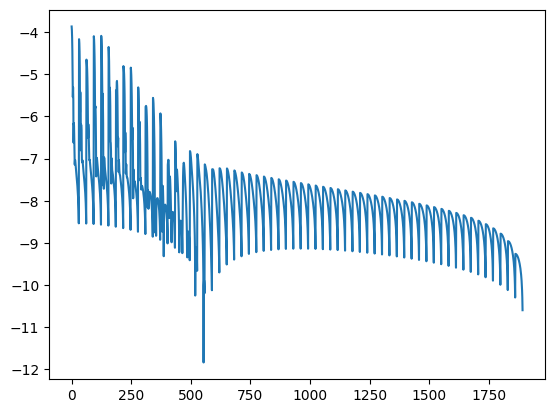

In [15]:
#initial data
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#intervalos
rho_plot = np.linspace(0, 3, 100) 
z_plot = np.linspace(-3, 3, 100)
Rhoplot, Zplot = np.meshgrid(rho_plot,z_plot)

RHO = np.repeat(rho_col, pz + 1)
# # np.savetxt('r_col_repeat6030', R, fmt='%.18f')
Z = np.tile(z_col, prho + 1)
# np.savetxt('x_col_repeat6030', X, fmt='%.18f')



# r0 = 5
def gaussian_exact(A0,r,z):
    return A0/2 * (np.exp(-(np.sqrt(r**2 + z**2) - 2)**2) + np.exp(-(np.sqrt(r**2 + z**2) + 2)**2)) * r**2 / (z**2 + r**2) 
    
# (exp(-(sqrt(rho.^2+z.^2)-2).^2)+exp(-(sqrt(rho.^2+z.^2)+2).^2)).*rho.^2./(z.^2+rho.^2)

gaussian_col_cyl = gaussian_exact(A0,RHO,Z)
# np.savetxt('phicol_6030L5_CYL', gaussian_col, fmt='%.18f')


# coef_col = [gaussian_exact(A0, r_col[j], x_col[k])
                         # for j in range(N + 1) for k in range(px + 1)]

a0 = np.dot(inv_psi_cyl, gaussian_col_cyl)

N = (prho + 1)*(pz+1)

N_array = np.linspace(0, N, N)

plt.plot(N_array, np.log10(abs(a0)))
plt.show()

In [104]:
'QUADRATURE ENERGY'

from numpy.polynomial.legendre import Legendre

Nqrho = int(3/2*prho)
Nqz = int(3/2*pz)
M = (Nqrho + 1)*(Nqz + 1)
L0 = Lr

Pqrho = Legendre.basis(Nqrho+1)   
Pqz = Legendre.basis(Nqz+1)  

dPrho = Pqrho.deriv()           
xqrho = Pqrho.roots()

dPz = Pqz.deriv()           
xqz = Pqz.roots()

#weights
wqrho = 2 / ((1 - xqrho**2) * (dPrho(xqrho)**2)) 
# np.savetxt('wqr', wqr, fmt='%.18e')

wqz = 2 / ((1 - xqz**2) * (dPz(xqz)**2))
# np.savetxt('wqz', wqz, fmt='%.18e')

# wq = np.tile(wqr, Nqx+1) * repelem(wqx, Nqr+1)
wq_cyl = np.kron(wqrho,wqz)
# print(wq.shape)
# np.savetxt('wqcol_N200L1_teste2', w_col, fmt='%.18e')

rhoq= Lr * (1 + xqrho) / (1 - xqrho)
# # Lr * (1 + xqr) / (1 - xqr) * np.sqrt(1 - xqr**2)
# # Lr * (1 + xqr) / (1 - xqr)
# # np.savetxt('rq6030L1', rq, fmt='%.18e')

zq = Lz * (1 + xqz) / (1 - xqz)
# Lz * (1 + xqz) / (1 - xqz) * xqz
# Lz * (1 + xqz) / (1 - xqz)
# np.savetxt('zq6030L1', zq, fmt='%.18e')

# ########################## Código do Patrick
# yq, wqrho = np.polynomial.legendre.leggauss(Nqrho + 1)
# rhoq = Lr * (1 + yq) / (1 - yq)

# xqz, wqz = np.polynomial.legendre.leggauss(Nqz + 1)
# zq = Lz * (1 + xqz) / (1 - xqz)

# wq_cyl = np.kron(wqrho,wqz)

###############quadrature
SBqua = np.zeros([prho+1, Nqrho+1]) #+1
rSBqua = np.zeros([prho+1, Nqrho+1])
# rrSBqua = np.zeros([prr+1, Nqr+1])

for i in range(prho+1):
    SBqua[i,] = np.sin((2*i+1)*np.arctan(Lr/rhoq))

for i in range(prho+1):
    rSBqua[i,] = -np.cos((2*i+1)*np.arctan(Lr/rhoq))*(2*i+1)*Lr/(rhoq**2*(1+Lr**2/rhoq**2))

# for i in range(pr+1):
#     rrSBqua[i,] = -np.sin((2*i+1)*np.arctan(L0/rq))*(2*i+1)**2*L0**2/(rq**4*(1+L0**2/rq**2)**2)
#     +2*np.cos((2*i+1)*np.arctan(L0/rq))*(2*i+1)*L0/(rq**3*(1+L0**2/rq**2))
#     -2*np.cos((2*i+1)*np.arctan(L0/rq))*(2*i+1)*L0**3/(rq**5*(1+L0**2/rq**2)**2)

SBq = SBqua.T
    # [0:(pr+1),:]
# psiq = psiplotpew.T
# np.savetxt('SBq_6030L4', SBq, fmt='%.18e')
# print('shape psi=', psiq.shape)
rSBq = rSBqua.T
# np.savetxt('rSBq_6030L4', rSBq, fmt='%.18e')
    # [0:(pr+1),:]
# rpsiq = rpsiplotpew.T  #/L0
# np.savetxt('rpsiq_N200L1_teste3', rpsiq, fmt='%.18e')
# print('rpsiplot=', rpsiq.shape)
# rrSBq = rrSBqua.T
    # [0:(pr+1), :]
# rrpsiq = rrpsiplotpew.T #/L0**2


###pi
SBpiqua = np.zeros([prho+1, Nqrho+1])
for k in range(prho+1):
    SBpiqua[k,] = (2*k+1) / (2*k+3)* (np.sin((2*k+2+1)*np.arctan(Lr/rhoq))) - (np.sin((2*k+1)*np.arctan(Lr/rhoq)))

# SBpiq = SBpiqua[0:(pr+1), :]
psipiq = SBpiqua.T
# np.savetxt('PIq_6030L4', psipiq, fmt='%.18e')


##### z
SBzqua = np.zeros([pz+1, Nqz+1]) #+1
zSBqua = np.zeros([pz+1, Nqz+1])
# zzSBqua = np.zeros([pz+1, Nqz+1])

for i in range(pz+1):
    SBzqua[i,] = np.sin((2*i+1)*np.arctan(Lz/zq))

for i in range(pz+1):
    zSBqua[i,] = -np.cos((2*i+1)*np.arctan(Lz/zq))*(2*i+1)*Lz/(zq**2*(1+Lz**2/zq**2))

# for i in range(pr+1):
#     zzSBqua[i,] = -np.sin((2*i+1)*np.arctan(L0/rq)z*(2*i+1)**2*L0**2/(rq**4*(1+L0**2/rq**2)**2)
#     +2*np.cos((2*i+1)*np.arctan(L0/rq))*(2*i+1)*L0/(rq**3*(1+L0**2/rq**2))
#     -2*np.cos((2*i+1)*np.arctan(L0/rq))*(2*i+1)*L0**3/(rq**5*(1+L0**2/rq**2)**2)

SBzq = SBzqua.T
# np.savetxt('SBzq_6030L4', SBzq, fmt='%.18e')
    # [0:(pr+1),:]
# psiq = psiplotpew.T
# np.savetxt('psiq_N200L1_teste3', psiq, fmt='%.18e')
# print('shape psi=', psiq.shape)
zSBq = zSBqua.T
# np.savetxt('dzSBq_6030L4', zSBq, fmt='%.18e')

    # [0:(pr+1),:]
# rpsiq = rpsiplotpew.T  #/L0
# np.savetxt('rpsiq_N200L1_teste3', rpsiq, fmt='%.18e')
# print('rpsiplot=', rpsiq.shape)
# zzSBq = zzSBqua.T
    # [0:(pr+1), :]
# rrpsiq = rrpsiplotpew.T #/L0**2




Psiq_cyl   = np.kron(SBq, SBzq) 
# np.savetxt('Psiq_6030L4', Psiq, fmt='%.18e')
Psipiq_cyl = np.kron(psipiq, SBzq)
# np.savetxt('PsiPIq_6030L4', Psipiq, fmt='%.18e')
# print(Psiq.shape)# shape: ((N+1)*(px+1), Nq+1)
rhoPsiq  = np.kron(rSBq, SBzq)
# np.savetxt('rPsiq_6030L4', rPsiq, fmt='%.18e')
# rrPsiq = np.kron(rrSBq, Pq)
zPsiq  = np.kron(SBq, zSBq)
# np.savetxt('zPsiq_6030L4', zPsiq, fmt='%.18e')
# xxPsiq = np.kron(SBq, xxPq)

In [105]:
import time

t0 = time.process_time()

N_cyl = (prho+1)*(pz+1)

j = np.repeat(rho_col, pz + 1)
# print(rho.shape)# shape: ( (N+1)*(px+1), )
z = np.tile(z_col, prho + 1)

rhoqrep = np.repeat(rhoq, Nqz + 1)
# np.savetxt('rqrep', rqrep, fmt='%.18e')

zqrep = np.tile(zq, Nqrho + 1)
# np.savetxt('zqrep', zqrep, fmt='%.18e')


def RHS_cyl(c):
    phi_r = np.dot(drhoPsi, c)
    phi_rr = np.dot(ddrhoPsi, c)
    # phi_x = np.dot(xPsi, c)
    phi_zz = np.dot(zzPsi, c)
    
    term1 = phi_r / j
    term2 = phi_rr
    term3 = phi_zz
    # term4 = (2 * x / r**2) * phi_x
    
    rhs = term1 + term2 + term3
    return rhs

# np.seterr(all='raise')  # levanta exceções para overflows, divisions by zero, etc.


# b0 = np.zeros(N_cyl)

h = 0.001
tf = 5
It = int(tf/h)
t = np.linspace(0, tf, It)

pi_setq_cyl = np.zeros([It,M])
drhophi_setq = np.zeros([It,M])
dzphi_setq = np.zeros([It,M])
energy_set_cyl = np.zeros(It)


# Phicenter = (-1) ** np.arange(N)
# phic = np.zeros(It)

# 'RK modes'

# for i in range(It):    

#     #first stanza
#     # a = np.dot(inv_psi_cyl, gaussian_col_cyl)
#     PI = np.dot(Psipi_cyl, b0)
#     dphi = PI
#     da1 = np.dot(inv_psi_cyl, dphi)

#     # phic[i] = np.dot(Phicenter, a0)

#     phi = np.dot(Psi_cyl, a0)
#     dPI = RHS(a0)
#     db1 = np.dot(inv_psipi_cyl, dPI)
    
#     # phi_setq[i,:] = np.dot(psiq, a)
#     drphi_setq[i,:] = np.dot(rPsiq, a0)
#     pi_setq[i,:]  = np.dot(Psipiq, b0)
#     dzphi_setq[i,:] = np.dot(zPsiq, a0)
#     # pi_setq[i,:]  = np.dot(psipiq, b)

#     #energy
#     rho = np.pi * 0.5 *  (pi_setq[i,:]**2 + drphi_setq[i,:]**2 + (1-xqrep**2)/rqrep**2 *  dxphi_setq[i,:]**2) * (rqrep+L0)**2 * rqrep**2/L0/2 
#     # rho = 0.5 * np.pi * (rq + L0)**2 * (pi_setq[i,:]**2 + drphi_setq[i,:]**2) * rq**2 / (2 * L0) 
#     # energia = 4 * np.dot(integrando, w)
#     energy_set[i] = 4 * np.dot(rho,wq)

#  #second stanza
#     newa = a0 + 0.5*h*da1
#     newb = b0 + 0.5*h*db1

#     PI = np.dot(Psi, newb)
#     dphi = PI
#     da2 = np.dot(inv_psi, dphi)
#     dPI = RHS(newa)
#     db2 = np.dot(inv_psi, dPI)

#     #third stanza
#     newa = a0+0.5*h*da2
#     newb = b0+0.5*h*db2

#     PI = np.dot(Psi, newb)
#     dphi = PI
#     da3 = np.dot(inv_psi, dphi)
#     dPI = RHS(newa)
#     db3 = np.dot(inv_psi, dPI)

#     #fourth stanza
#     newa = a0 + h*da3
#     newb = b0 + h*db3

#     PI = np.dot(Psi, newb)
#     dphi = PI
#     da4 = np.dot(inv_psi, dphi)
#     dPI = RHS(newa)
#     db4 = np.dot(inv_psi, dPI)
    
#     a0 = a0 + 1/6 * h*da1 + 1/3 * h*da2 + 1/3 * h*da3 + 1/6 * h*da4
#     b0 = b0 + 1/6 * h*db1 + 1/3 * h*db2 + 1/3 * h*db3 + 1/6 * h*db4


#     # phi_set[i,:] = np.dot(psiplot, a)
#     # drphi_set[i,:] = np.dot(rpsiplot, a)
#     pi_set[i,:]  = np.dot(psipi_plot, b)

PI = np.zeros(N_cyl)
phi = gaussian_col_cyl
phic_cyl = np.zeros(It)

Phicenter = (-1) ** np.arange(N_cyl)

'RK values'

with open(f'V_phic_CYL_PR{prho}PZ{pz}LR{Lr}LZ{Lz}_test', 'w') as phic_file, \
     open(f'V_energy_CYL_PR{prho}PZ{pz}LR{Lr}LZ{Lz}_test', 'w') as Pteste_energy_file:
         for i in range(It):
             
             ##First stanza
             dphi1 = PI
             a = inv_psi_cyl @ phi

             # drphi = drhoPsi @ a
             # ddrphi = ddrhoPsi @ a
             # ddzphi = zzPsi @ a
             dPI1 = RHS_cyl(a) 
             # dPI1 = ddrphi + drphi/j + ddzphi

             ##calculating energy by gauss legendre integration
             b = inv_psipi_cyl @ PI
             PIq = Psipiq_cyl @ b
             drphiq = rhoPsiq @ a
             dzphiq = zPsiq @ a

             # IntE = 0.5 * (PIq*2 + drphiq2 + dzphiq2) (Rq + LR)*2 * Rq * (Zq + LZ)*2/4
             IntE = 0.5 *(PIq**2 + drphiq**2 + dzphiq**2) *(rhoqrep + Lr)**2 / (2*Lr) * rhoqrep * (zqrep + Lz)**2/(2*Lz)
              # 0.5 *(PIq**2 + drphiq**2 + dzphiq**2) *(rqrep + Lr)**2 * rqrep * (zqrep + Lz)**2/4
             Energy = 4 * IntE @ wq_cyl
             # saving energy data
             Energy_line = f"{t[i]:.6e} " + " ".join([f"{val:.16e}" for val in Energy.flatten()])
             Pteste_energy_file.write(Energy_line + "\n")

             ##Second stanza
             newphi = phi + 0.5 * h * dphi1
             newPI = PI + 0.5 * h * dPI1
             
             dphi2 = newPI
             a = inv_psi_cyl @ newphi

             # drphi = drhoPsi @ a
             # ddrphi = ddrhoPsi @ a
             # ddzphi = zzPsi @ a
             dPI2 = RHS_cyl(a)
             # dPI2 = ddrphi + drphi/j + ddzphi

             ##Third Stanza
             newphi = phi + 0.5 * h * dphi2
             newPI = PI + 0.5 * h * dPI2

             dphi3 = newPI
             a = inv_psi_cyl @ newphi

             # drphi = drhoPsi @ a
             # ddrphi = ddrhoPsi @ a
             # ddzphi = zzPsi @ a
             dPI3 = RHS_cyl(a) 
             # dPI3 = ddrphi + drphi/j + ddzphi

             ##Fourth Stanza
             newphi = phi + h * dphi3
             newPI = PI + h * dPI3

             dphi4 = newPI
             a = inv_psi_cyl @ newphi

             # drphi = drhoPsi @ a
             # ddrphi = ddrhoPsi @ a
             # ddzphi = zzPsi @ a
             dPI4 = RHS_cyl(a) 
             # dPI4 = ddrphi + drphi/j + ddzphi

             ##Incrementando as variáveis
             phi = phi + 1/6 * h * dphi1 + 1/3 * h * dphi2 + 1/3 * h * dphi3 + 1/6 * h * dphi4
             PI = PI + 1/6 * h * dPI1 + 1/3 * h * dPI2 + 1/3 * h * dPI3 + 1/6 * h * dPI4

             phic = Phicenter @ a

             #Saving phic data
             phic_line = f"{t[i]:.6f} " + " ".join([f"{val:.16e}" for val in phic.flatten()])
             phic_file.write(phic_line + "\n")

              


# for i in range(It):    

#     #first stanza
#     dphi1 = PI
#     a0 = np.dot(inv_psi_cyl, phi)
#     # phic[i] = np.dot(Phicenter, a0)
    
#     dPI1 = RHS_cyl(a0)
#     # drphi = rPsi @ a0
#     # ddrphi = rrPsi @ a0
#     # ddzphi = zzPsi @ a0
#     # dPI1 = ddrphi + drphi/j + ddzphi
    
#     b_cyl = np.dot(inv_psipi_cyl, PI)
    
#     # phi_setq[i,:] = np.dot(psiq, a)
#     drhophi_setq[i,:] = np.dot(rhoPsiq, a0)
#     pi_setq_cyl[i,:]  = np.dot(Psipiq_cyl, b_cyl)
#     dzphi_setq[i,:] = np.dot(zPsiq, a0)

#     #energy
#     IntE = 0.5 * (pi_setq_cyl[i,:]**2 + drhophi_setq[i,:]**2 + dzphi_setq[i,:]**2) * (rhoqrep+Lr)**2 * (rhoqrep) * (zqrep+Lz)**2 / (4 * Lr * Lz)
#     # 0.5 *  (pi_setq[i,:]**2 + drphi_setq[i,:]**2 + dzphi_setq[i,:]**2) * (rqrep+Lr)**2 * (rqrep) * (zqrep+Lz)**2/4
#     # rho = 0.5 * np.pi * (rq + L0)**2 * (pi_setq[i,:]**2 + drphi_setq[i,:]**2) * rq**2 / (2 * L0) 
#     # energia = 4 * np.dot(integrando, w)
#     energy_set_cyl[i] = 4 * np.dot(IntE,wq_cyl)

#     # b = inv_psipi @ PI
#     # PIq = Psipiq @ b
#     # drphiq = rPsiq @ a0
#     # dzphiq = zPsiq @ a0

#     # # Calculando integrando da energia
#     # IntE = 0.5 * (PIq**2 + drphiq**2 + dzphiq**2) * (rqrep + Lr)**2 * rqrep * (zqrep + Lz)**2 / 4
#     # energy_set[i] = 4 * np.dot(IntE, wq)

#  #second stanza
#     newphi = phi+0.5*h*dphi1
#     newPI = PI+0.5*h*dPI1

#     dphi2 = newphi
#     a0 = np.dot(inv_psi_cyl, newphi)
#     # print(a0.shape)
#     dPI2 = RHS_cyl(a0)
#     # drphi = rPsi @ a0
#     # ddrphi = rrPsi @ a0
#     # ddzphi = zzPsi @ a0
#     # dPI2 = ddrphi + drphi/j + ddzphi

#     #third stanza
#     newphi = phi+0.5*h*dphi2
#     newPI = PI+0.5*h*dPI2

#     dphi3 = newPI
#     a0 = np.dot(inv_psi_cyl, newphi)
#     dPI3 = RHS_cyl(a0)
#     # drphi = rPsi @ a0
#     # ddrphi = rrPsi @ a0
#     # ddzphi = zzPsi @ a0
#     # dPI3 = ddrphi + drphi/j + ddzphi

#     #fourth stanza
#     newphi = phi+h*dphi3
#     newPI = PI+h*dPI3

#     dphi4 = newPI
#     a0 = np.dot(inv_psi_cyl, newphi)
#     dPI4 = RHS_cyl(a0)
#     # drphi = rPsi @ a0
#     # ddrphi = rrPsi @ a0
#     # ddzphi = zzPsi @ a0
#     # dPI4 = ddrphi + drphi/j + ddzphi

#     phi = phi + 1/6 * h * dphi1 + 1/3 * h * dphi2 + 1/3 * h * dphi3 + 1/6 * h * dphi4
#     PI = PI + 1/6 * h * dPI1 + 1/3 * h * dPI2 + 1/3 * h * dPI3 + 1/6 * h * dPI4

#     phic_cyl[i] = np.dot(Phicenter, a0)


# # # # # #     # phi_set[i,:] = np.dot(psiplot, a)
# # # # # #     # drphi_set[i,:] = np.dot(rpsiplot, a)
# # # # # #     # pi_set[i,:]  = np.dot(psipi_plot, b)


# # # # # print("Saving results in txt files")

# np.savetxt('phic_CYL_6030L5_values', phic_cyl, fmt='%.16e')
# np.savetxt('energy_CYL_6030L5_values', energy_set_cyl, fmt='%.16e')
# np.savetxt('a_N60P30L5_modes_H', a0, fmt='%.16e')
# np.savetxt('a0_sphercoor_2000_L5', a_set, fmt='%.15e')

# print(f"t = {t[i]:.6f}")
# print(f"phi sample = {phi[:3]}")
# print(f"PI sample = {PI[:3]}")
# print(f"Energy = {energy_set[i]}")

   
t1 = time.process_time()
print('Running time (basis):', t1 - t0, 's')

Running time (basis): 17641.203125 s
